Rotate the Wind

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

Calculate the angle of rotation of the grid (based on
http://www.movable-type.co.uk/scripts/latlong.html?from=49.243824,-121.887340&to=49.227648,-121.89631 )        
I have changed it so that it is NOT bearing but the angle (which increases counter-clockwise) from due East

In [2]:
def angle(lat1, lon1, lat2, lon2, direction):
    dellon = lon2 - lon1
    Ycomp = np.sin(dellon) * np.cos(lat2)
    Xcomp = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dellon)
    if direction == 'X':
        da = np.pi/2
    elif direction == 'Y':
        da = 0
    return np.arctan2(-Ycomp, Xcomp) + da

Some basic testing to make sure I set it up okay

In [4]:
lat1 = 0.
lat2 = -0.001
lon1 = 0.
lon2 = 0.001
angle(lat1, lon1, lat2, lon2, 'X') * 180 / np.pi

-45.00001432394728

Now read in our raw grib files

In [5]:
data_u = xr.open_dataset('/results/forcing/atmospheric/continental2.5/GRIB/20230215/00/001/20230215T00Z_MSC_HRDPS_UGRD_AGL-10m_RLatLon0.0225_PT001H.grib2',
                        engine='cfgrib')

In [6]:
data_v = xr.open_dataset('/results/forcing/atmospheric/continental2.5/GRIB/20230215/00/001/20230215T00Z_MSC_HRDPS_VGRD_AGL-10m_RLatLon0.0225_PT001H.grib2',
                        engine='cfgrib')

Crop to our SalishSeaCast domain and make everything numpy arrays

In [7]:
imin, imax = 230, 460
jmin, jmax = 300, 490

In [8]:
lats = np.array(data_u.latitude[imin:imax+1, jmin:jmax+1])
lons = np.array(data_u.longitude[imin:imax+1, jmin:jmax+1])
uus = np.array(data_u.u10[imin:imax, jmin:jmax])
vvs = np.array(data_v.v10[imin:imax, jmin:jmax])

Calculate our 2D grid of angles
* problems in lower part of the plot, tried going left as well as right, no difference

In [9]:
angles1 = angle(lats[:-1, :-1], lons[:-1, :-1], lats[:-1, 1:], lons[:-1, 1:], 'X')
angles2 = angle(lats[:-1, :-1], lons[:-1, :-1], lats[1:, :-1], lons[1:, :-1], 'Y')

In [10]:
angles = 0.5 * (angles1 + angles2)

Rotate our winds based on our angles

In [11]:
u_wind = uus * np.cos(angles) - vvs * np.sin(angles)
v_wind = uus * np.sin(angles) + vvs * np.cos(angles)

## Plots ##
* Raw (red) versus Rotated (blue)
* Raw (red) versus netcdf file based on western grid (black)
* Rotated (blue) versus netcdf file based on western grid (black)

* Rotated 'X' only (blue) versus wgrib2 rotated velocities (magenta)
* Rotated 'Y' only (blue) versus wgrib2 rotated velocities (magenta)
* Rotated (blue) versus wgrib2 rotated velocities (magenta)

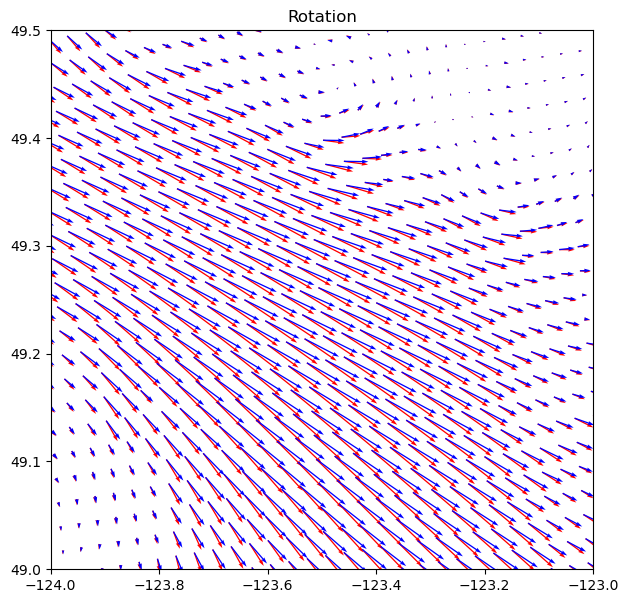

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.quiver(lons[:-1, :-1], lats[:-1, :-1], uus, vvs, scale=100, color='r')
ax.quiver(lons[:-1, :-1], lats[:-1, :-1], u_wind, v_wind, scale=100, color='b')
ax.set_ylim(49, 49.5);
ax.set_xlim(236-360, 237-360);
ax.set_title('Rotation');

In [14]:
olddata = xr.open_dataset('/results/forcing/atmospheric/GEM2.5/operational/ops_y2023m02d15.nc')

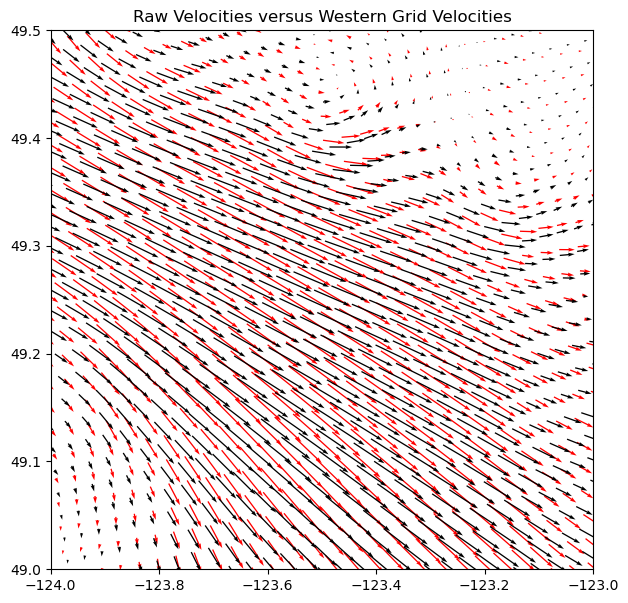

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.quiver(lons[:-1, :-1], lats[:-1, :-1], uus, vvs, scale=100, color='r')
ax.quiver(np.array(olddata.nav_lon)-360, np.array(olddata.nav_lat), np.array(olddata.u_wind[1]), np.array(olddata.v_wind[1]), scale=100)
ax.set_ylim(49, 49.5);
ax.set_xlim(236-360, 237-360);
ax.set_title('Raw Velocities versus Western Grid Velocities');

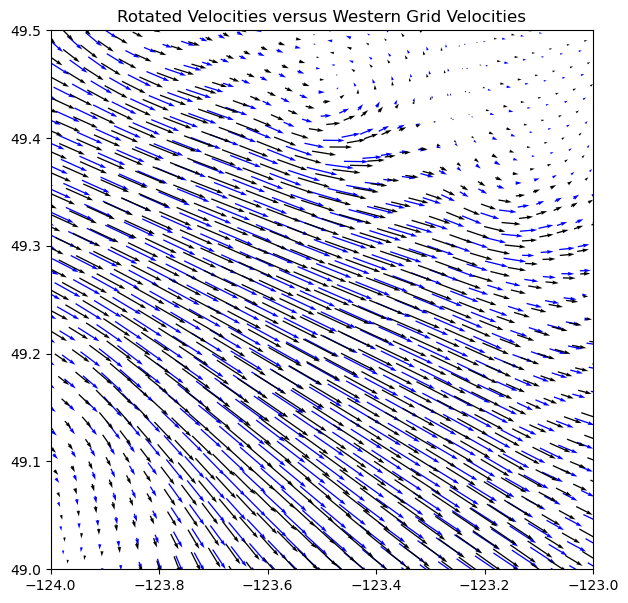

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.quiver(lons[:-1, :-1], lats[:-1, :-1], u_wind, v_wind, scale=100, color='b')
ax.quiver(np.array(olddata.nav_lon)-360, np.array(olddata.nav_lat), np.array(olddata.u_wind[1]), np.array(olddata.v_wind[1]), scale=100)
ax.set_ylim(49, 49.5);
ax.set_xlim(236-360, 237-360);
ax.set_title('Rotated Velocities versus Western Grid Velocities');

Velocities rotated by GRIB

In [19]:
data = xr.open_dataset('/data/sallen/results/uvrot_py.grib',
                      engine='cfgrib')

In [20]:
u_wind = uus * np.cos(angles1) - vvs * np.sin(angles1)
v_wind = uus * np.sin(angles1) + vvs * np.cos(angles1)

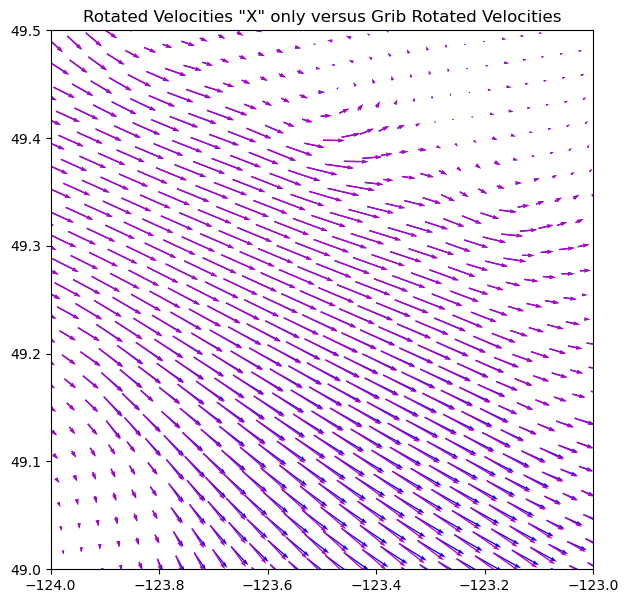

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.quiver(lons[:-1, :-1], lats[:-1, :-1], u_wind, v_wind, scale=100, color='b')
ax.set_ylim(49, 49.5);
ax.set_xlim(236-360, 237-360);
ax.set_title('Rotated Velocities "X" only versus Grib Rotated Velocities');
ax.quiver(np.array(data.longitude[imin:imax, jmin:jmax]), np.array(data.latitude[imin:imax, jmin:jmax]), 
          np.array(data.u10[imin:imax, jmin:jmax]), np.array(data.v10[imin:imax, jmin:jmax]), scale=100, color='m');

In [22]:
u_wind = uus * np.cos(angles2) - vvs * np.sin(angles2)
v_wind = uus * np.sin(angles2) + vvs * np.cos(angles2)

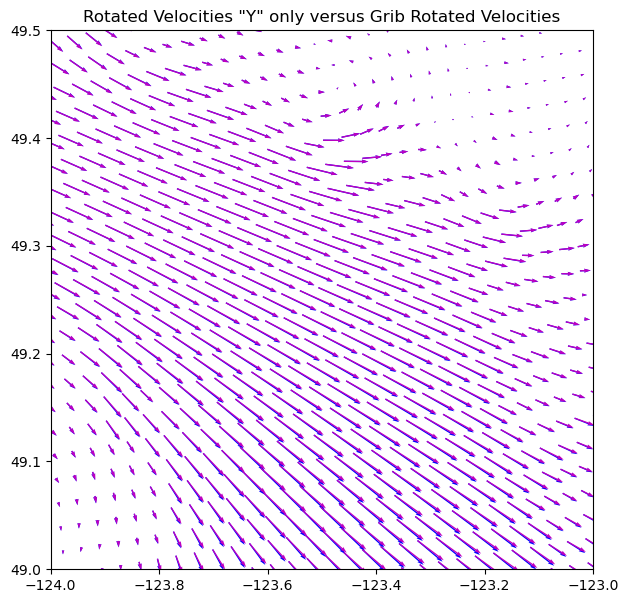

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.quiver(lons[:-1, :-1], lats[:-1, :-1], u_wind, v_wind, scale=100, color='b')
ax.set_ylim(49, 49.5);
ax.set_xlim(236-360, 237-360);
ax.set_title('Rotated Velocities "Y" only versus Grib Rotated Velocities');
ax.quiver(np.array(data.longitude[imin:imax, jmin:jmax]), np.array(data.latitude[imin:imax, jmin:jmax]), 
          np.array(data.u10[imin:imax, jmin:jmax]), np.array(data.v10[imin:imax, jmin:jmax]), scale=100, color='m');

In [24]:
u_wind = uus * np.cos(angles) - vvs * np.sin(angles)
v_wind = uus * np.sin(angles) + vvs * np.cos(angles)

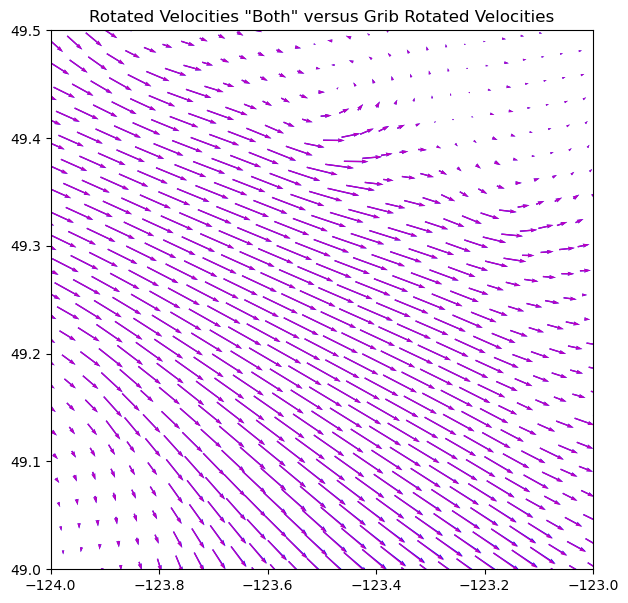

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.quiver(lons[:-1, :-1], lats[:-1, :-1], u_wind, v_wind, scale=100, color='b')
ax.set_ylim(49, 49.5);
ax.set_xlim(236-360, 237-360);
ax.set_title('Rotated Velocities "Both" versus Grib Rotated Velocities');
ax.quiver(np.array(data.longitude[imin:imax, jmin:jmax]), np.array(data.latitude[imin:imax, jmin:jmax]), 
          np.array(data.u10[imin:imax, jmin:jmax]), np.array(data.v10[imin:imax, jmin:jmax]), scale=100, color='m');